In [8]:
import sys
import os

# Ajouter le dossier parent au path
sys.path.append(os.path.abspath(os.path.join('..')))

# Ensuite tu peux importer ton module
import utils

In [9]:
# Cell 1 — Imports
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import Birch, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler


In [10]:
# Cell 2 — Réglages (modifiable rapidement)
DATA_GLOB = "../../reduced_data/*.csv"

# Clustering params
N_CLUSTERS = 3          # nombre de clusters pour Ward et (optionnel) BIRCH
BIRCH_THRESHOLD = 0.30  # seuil BIRCH (affine la granularité)
STANDARDIZE = False     # True si vous voulez standardiser avant clustering
RANDOM_STATE = 0        # pour reproductibilité (Ward n'a pas de random_state)

# Affichage
POINT_SIZE = 35
EDGE_COL = "k"
FIGSIZE = (6, 5)
ALPHA = 0.85


In [11]:
# Cell 3 — Utilitaires
def pick_numeric_2d(df: pd.DataFrame):
    """Retourne (X2d, cols_numeric) où X2d est un DataFrame avec 2 colonnes numériques.
    Prend les deux premières colonnes numériques; si <2, retourne (None, None)."""
    num = df.select_dtypes(include=[np.number]).copy()
    if num.shape[1] < 2:
        return None, None
    # Garde l'ordre d'apparition des colonnes
    X2d = num.iloc[:, :2].copy()
    return X2d, num.columns.tolist()

def maybe_standardize(X: pd.DataFrame, enable: bool):
    if not enable:
        return X.values
    return StandardScaler().fit_transform(X.values)

def plot_clusters_2d(X2d: pd.DataFrame, labels, title: str):
    plt.figure(figsize=FIGSIZE)
    scatter = plt.scatter(X2d.iloc[:, 0], X2d.iloc[:, 1],
                          c=labels, s=POINT_SIZE, edgecolors=EDGE_COL, alpha=ALPHA)
    plt.xlabel(X2d.columns[0])
    plt.ylabel(X2d.columns[1])
    plt.title(title)
    # Légende simple avec nombres de points par cluster
    uniq, counts = np.unique(labels, return_counts=True)
    legend_text = [f"Cluster {u} (n={c})" for u, c in zip(uniq, counts)]
    # Crée des handles factices pour la légende
    handles = [plt.Line2D([0],[0], marker='o', linestyle='', markersize=8) for _ in legend_text]
    plt.legend(handles, legend_text, loc="best", frameon=True)
    plt.tight_layout()
    plt.show()


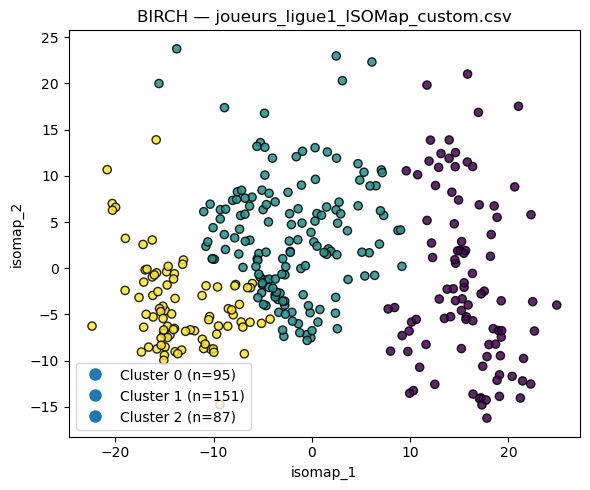

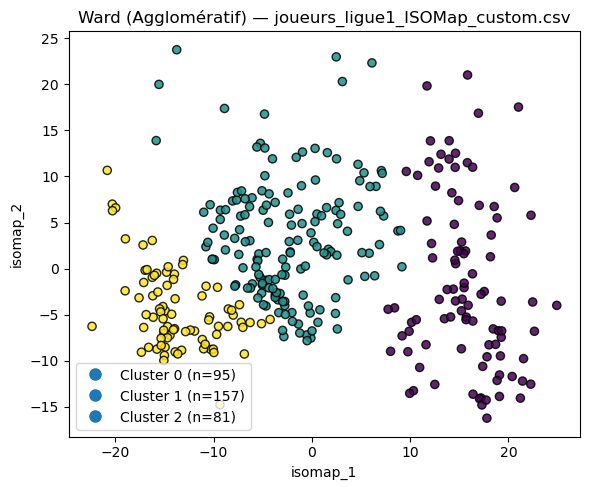

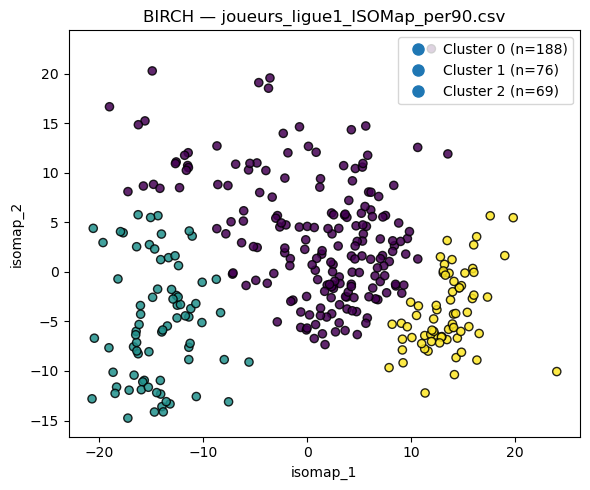

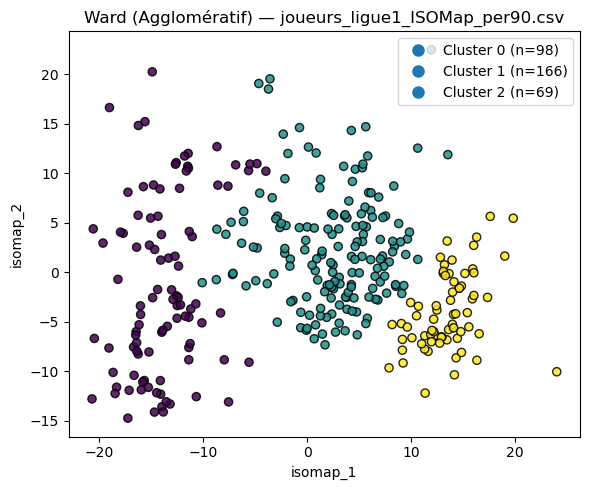

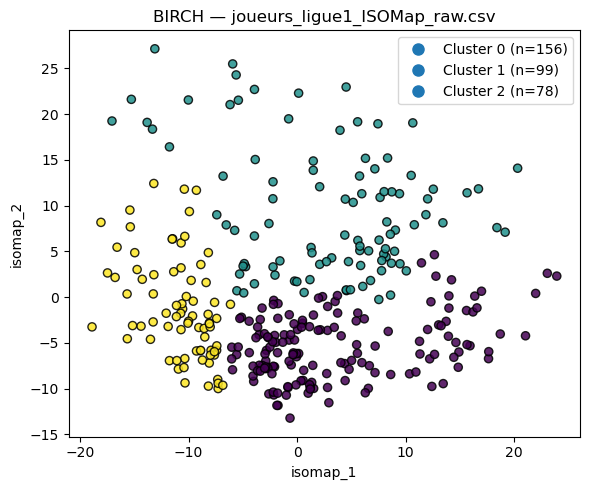

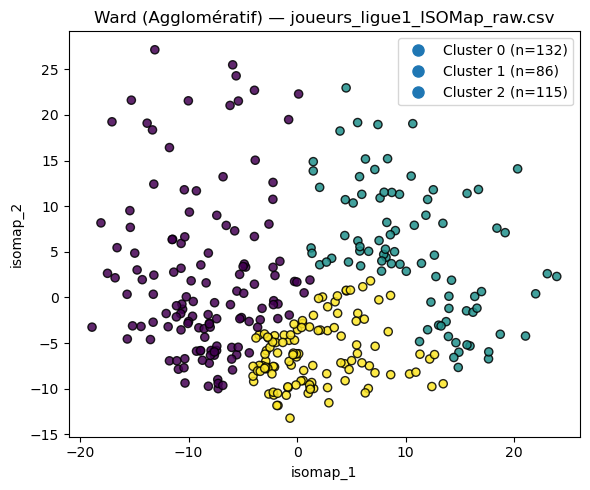

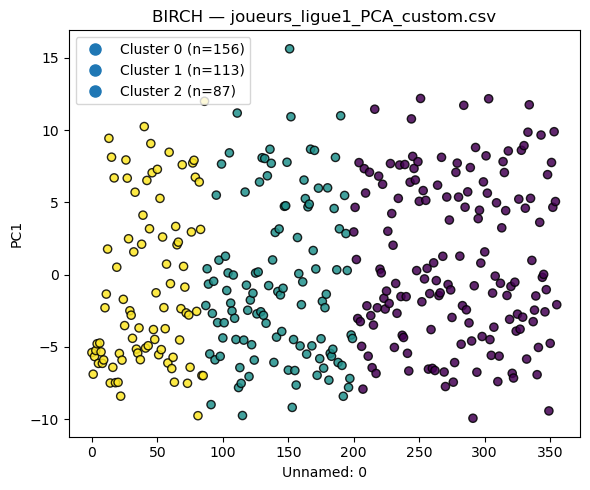

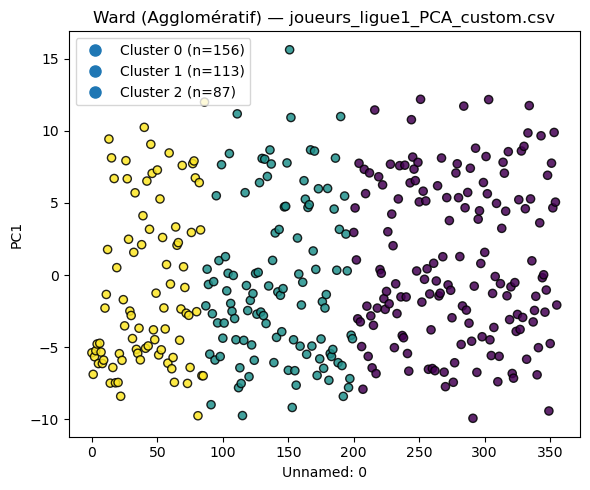

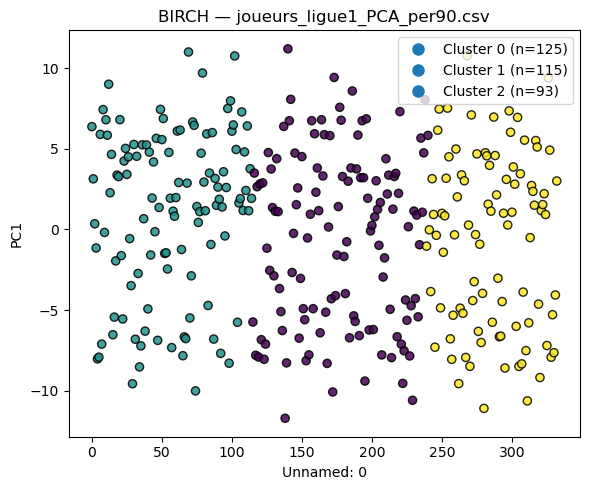

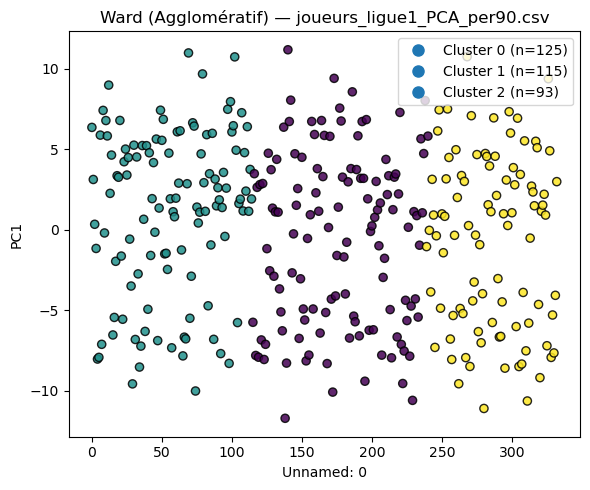

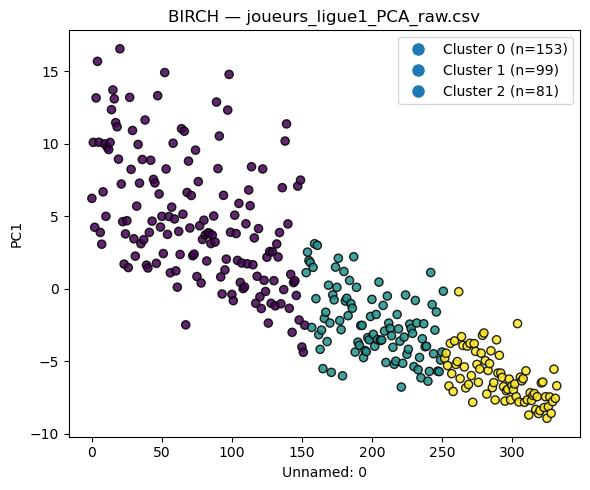

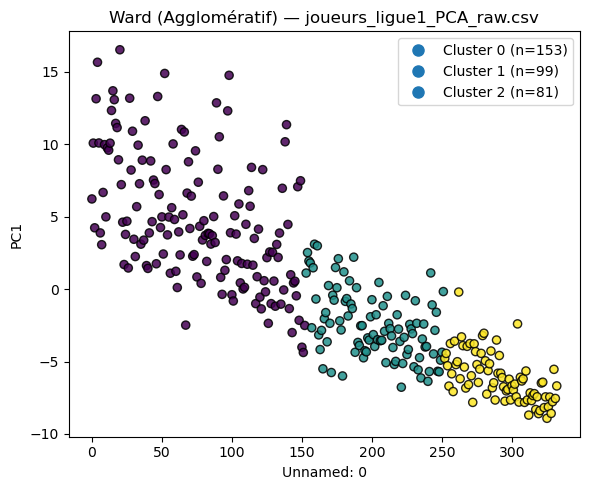

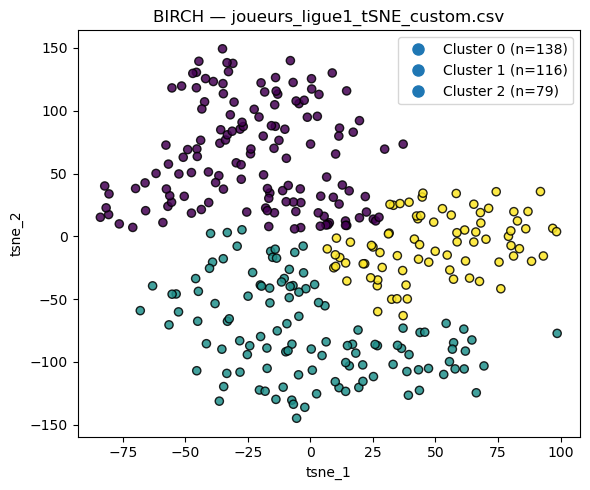

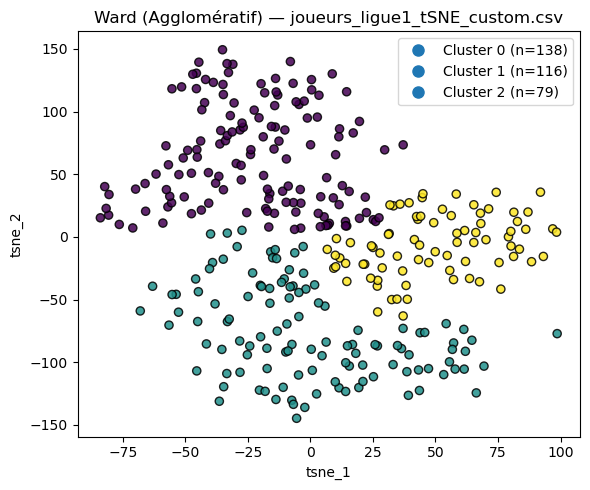

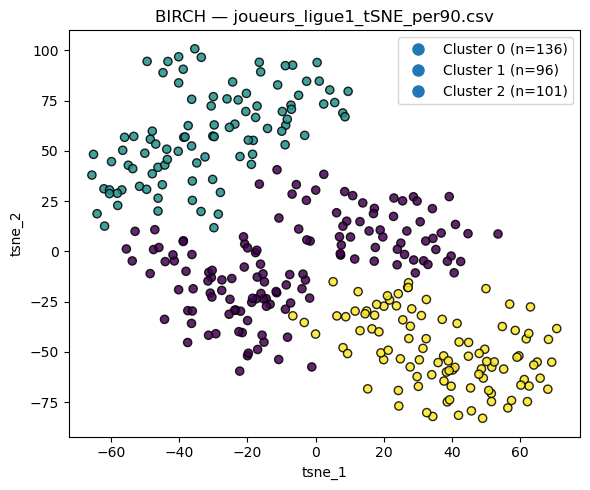

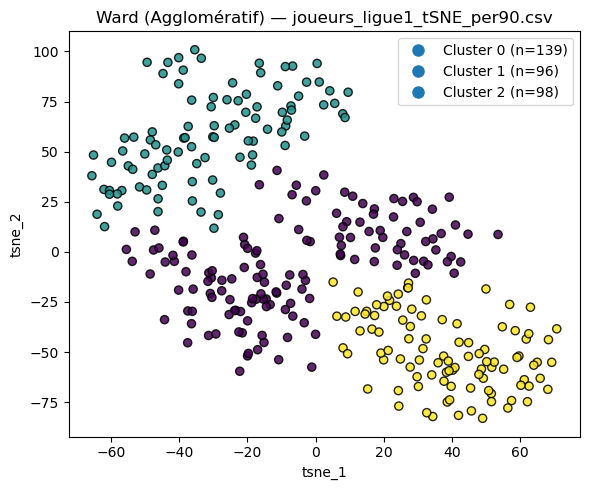

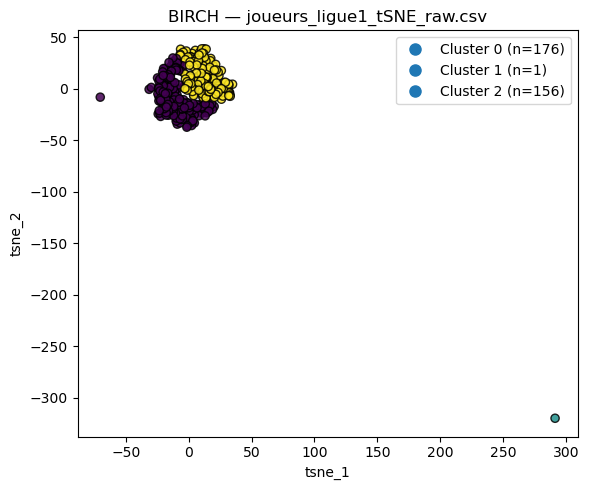

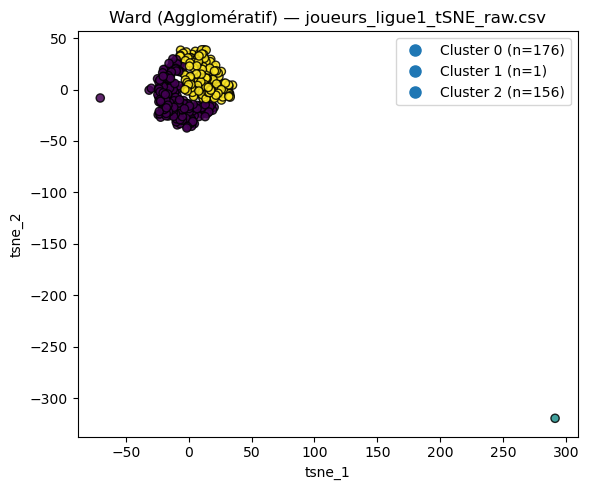

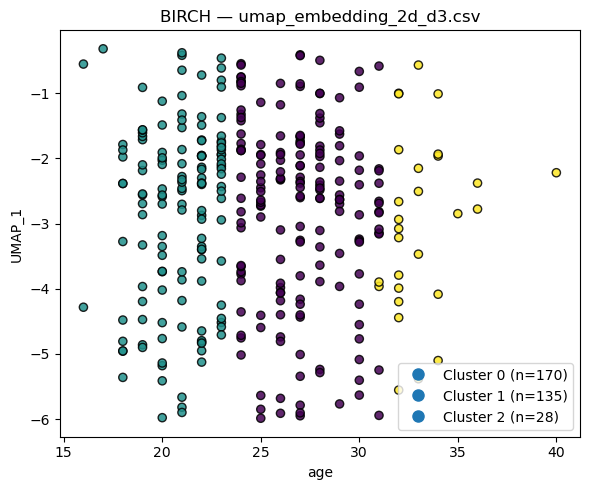

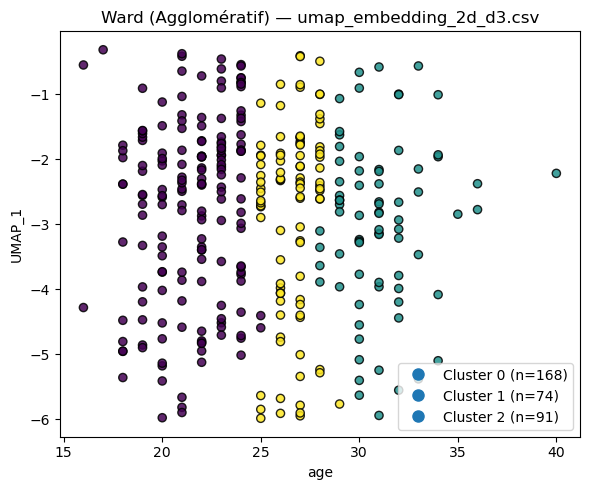

In [12]:
# Cell 4 — Boucle principale : chargement, clustering, affichage
csv_files = sorted(glob.glob(DATA_GLOB))
if not csv_files:
    print(f"Aucun fichier trouvé avec le motif : {DATA_GLOB}")

for path in csv_files:
    df = pd.read_csv(path)
    X2d, numeric_cols = pick_numeric_2d(df)
    fname = os.path.basename(path)

    if X2d is None:
        print(f"[SKIP] {fname} — moins de 2 colonnes numériques.")
        continue

    X_mat = maybe_standardize(X2d, STANDARDIZE)

    # --- BIRCH ---
    # Si vous voulez laisser BIRCH déterminer les clusters, mettez n_clusters=None
    birch = Birch(threshold=BIRCH_THRESHOLD, n_clusters=N_CLUSTERS)
    birch_labels = birch.fit_predict(X_mat)
    plot_clusters_2d(X2d, birch_labels, title=f"BIRCH — {fname}")

    # --- Ward (Agglomerative) ---
    ward = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage="ward")
    ward_labels = ward.fit_predict(X_mat)
    plot_clusters_2d(X2d, ward_labels, title=f"Ward (Agglomératif) — {fname}")


In [13]:
# Cell 4 — Boucle principale : chargement, clustering, affichage (INTERACTIF)
csv_files = sorted(glob.glob(DATA_GLOB))
if not csv_files:
    print(f"Aucun fichier trouvé avec le motif : {DATA_GLOB}")

for path in csv_files:
    df = pd.read_csv(path)
    X2d, numeric_cols = pick_numeric_2d(df)
    fname = os.path.basename(path)

    if X2d is None:
        print(f"[SKIP] {fname} — moins de 2 colonnes numériques.")
        continue

    # Méta pour hover
    meta_cols = [c for c in ["player_name", "position"] if c in df.columns]
    meta = df.loc[X2d.index, meta_cols] if meta_cols else pd.DataFrame(index=X2d.index)

    X_mat = maybe_standardize(X2d, STANDARDIZE)

    # --- BIRCH ---
    birch = Birch(threshold=BIRCH_THRESHOLD, n_clusters=N_CLUSTERS)
    birch_labels = birch.fit_predict(X_mat)
    birch_df = pd.concat([X2d.copy(), meta], axis=1)
    birch_df["cluster"] = birch_labels
    birch_df["file"] = fname

    fig_birch = px.scatter(
        birch_df,
        x=birch_df.columns[0],
        y=birch_df.columns[1],
        color="cluster",
        hover_name=("player_name" if "player_name" in birch_df.columns else None),
        hover_data=[c for c in ["position", "cluster", "file"] if c in birch_df.columns],
        title=f"BIRCH — {fname}"
    )
    fig_birch.update_traces(marker=dict(size=8, line=dict(width=0.5)))
    fig_birch.update_layout(margin=dict(l=10, r=10, t=40, b=10))
    fig_birch.show()

    # --- Ward (Agglomerative) ---
    ward = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage="ward")
    ward_labels = ward.fit_predict(X_mat)
    ward_df = pd.concat([X2d.copy(), meta], axis=1)
    ward_df["cluster"] = ward_labels
    ward_df["file"] = fname

    fig_ward = px.scatter(
        ward_df,
        x=ward_df.columns[0],
        y=ward_df.columns[1],
        color="cluster",
        hover_name=("player_name" if "player_name" in ward_df.columns else None),
        hover_data=[c for c in ["position", "cluster", "file"] if c in ward_df.columns],
        title=f"Ward (Agglomératif) — {fname}"
    )
    fig_ward.update_traces(marker=dict(size=8, line=dict(width=0.5)))
    fig_ward.update_layout(margin=dict(l=10, r=10, t=40, b=10))
    fig_ward.show()


[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
[2] Sandbox: CanCreateUs